In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
import re
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import lightgbm as lgb

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [62]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# from utils import preprocess_features, sort_df, make_x, make_y

In [64]:
df_train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})

In [65]:
df_train_preprocessed = utils.preprocess_features(df_train)

In [66]:
X_train = utils.make_x(df_train_preprocessed)
y_train = utils.make_y(X_train, df_train_preprocessed)

In [67]:
X_train.shape, y_train.shape

((23171, 309), (23171, 199))

In [68]:
pd.isna(X_train).any()

pl1_X                            False
pl1_Y                            False
pl1_S                            False
pl1_A                            False
pl1_Dis                          False
pl1_Orientation                  False
pl1_Dir                          False
pl1_JerseyNumber                 False
pl1_PlayerHeight                 False
pl1_PlayerWeight                 False
pl1_PlayerBMI                    False
pl1_PlayerAge                    False
pl2_X                            False
pl2_Y                            False
pl2_S                            False
pl2_A                            False
pl2_Dis                          False
pl2_Orientation                  False
pl2_Dir                          False
pl2_JerseyNumber                 False
pl2_PlayerHeight                 False
pl2_PlayerWeight                 False
pl2_PlayerBMI                    False
pl2_PlayerAge                    False
pl3_X                            False
pl3_Y                    

In [69]:
X_train.head()

,pl1_X,pl1_Y,pl1_S,pl1_A,pl1_Dis,pl1_Orientation,pl1_Dir,pl1_JerseyNumber,pl1_PlayerHeight,pl1_PlayerWeight,...,def_DB,def_OL,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR
PlayId,,,,,,,,,,,,,,,,,,,,,
20170907000118,46.09,34.84,1.69,1.13,0.40,278.01,182.82,29.0,72.0,212.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
20170907000139,54.27,33.88,1.53,2.16,0.20,289.70,194.30,29.0,72.0,212.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
20170907000189,75.25,26.53,3.77,2.95,0.44,287.40,191.84,29.0,72.0,212.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
20170907000345,108.09,22.64,1.10,0.83,0.28,24.47,250.74,98.0,73.0,301.0,...,3.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,2.0,0.0
20170907000395,35.70,36.00,0.96,3.26,0.00,160.43,172.71,23.0,71.0,215.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0


# Helper functions

In [70]:
#from https://www.kaggle.com/davidcairuz/nfl-neural-network-w-softmax
def crps(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred), axis=1)

In [71]:
def yard_to_cdf(yard):
    yard = np.round(yard).astype(int)
    indices = yard+99
    cdfs = np.zeros((yard.shape[0], 199))
    for i in range(len(cdfs)):
        cdfs[i, indices[i]:] = 1
    return cdfs

def cdf_to_yard(cdf):
    yard_index = (cdf==1).argmax(axis=1)
    yard = yard_index-99
    return yard

In [72]:
# Turn yard cdf to yard number, \in (-99, 99)
y_train_yard_num = cdf_to_yard(y_train)
assert y_train_yard_num[0] == 8
print(y_train_yard_num)

[ 8  3  5 ...  4  2 11]


In [73]:
yard_to_cdf(y_train_yard_num)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [74]:
assert (yard_to_cdf(y_train_yard_num) == y_train).all()

In [75]:
crps(y_train[:1], y_train[:1])

array([0.])

# Define CV scheme

In [ ]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5)

# Scale data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_train[:10]

# Model CV

In [ ]:
sns.distplot(y_train_yard_num)
plt.title('Yard number distribution')
plt.show()

In [ ]:
def lgb_cprs_eval(preds, train_data):
    yards_true = train_data.label
    eval_name, is_higher_better = 'mean crps', False
    pred_cdfs = yard_to_cdf(preds)
    true_cdfs = yard_to_cdf(yards_true)
    errors = crps(true_cdfs, pred_cdfs)
    eval_result = np.mean(errors)
    return eval_name, eval_result, is_higher_better

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train_yard_num,
                       categorical_feature='auto')

In [ ]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'mae'},
    'metric_freq': 5,
    'early_stopping_round': 100,
    'max_bin': 255,
    'learning_rate': 0.01,
    'tree_learner': 'serial',
    'verbose': 1,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

In [ ]:
eval_hist = lgb.cv(params=lgb_params, train_set=lgb_train, folds=cv.split(X_train, y_train), feval=lgb_cprs_eval)

In [ ]:
plt.figure()
sns.distplot(eval_hist['mean crps-mean'])
plt.title('mean score')
plt.show()
print('Mean loss', np.mean(eval_hist['mean crps-mean']))

In [ ]:
plt.figure()
sns.distplot(eval_hist['l1-mean'])
plt.title('MAE')
plt.show()
print('Mean MAE', np.mean(eval_hist['l1-mean']))

# Evaluation

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_val, y_train_num, y_val_num = train_test_split(X_train, y_train_yard_num,
                                        test_size=0.2)


In [92]:
train_data = lgb.Dataset(X_train, y_train_num,
                       categorical_feature='auto')
val_data = lgb.Dataset(X_val, y_val_num,
                       categorical_feature='auto')

lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'mae'},
    'metric_freq': 5,
    'early_stopping_round': 200,
    'max_bin': 255,
    'max_depth': 4,
    'learning_rate': 0.01,
#     'num_leaves': 31,
    'tree_learner': 'serial',
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01
}
num_iterations = 10000
bst = lgb.train(lgb_params, train_data, num_iterations, valid_sets=[val_data], feval=lgb_cprs_eval)

/home/boris/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 3.72424	valid_0's mean crps: 0.0187258
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 3.72209	valid_0's mean crps: 0.0187258
[3]	valid_0's l1: 3.71977	valid_0's mean crps: 0.0187258
[4]	valid_0's l1: 3.71777	valid_0's mean crps: 0.0187258
[5]	valid_0's l1: 3.7159	valid_0's mean crps: 0.0187258
[6]	valid_0's l1: 3.71369	valid_0's mean crps: 0.0187258
[7]	valid_0's l1: 3.7111	valid_0's mean crps: 0.0187258
[8]	valid_0's l1: 3.70911	valid_0's mean crps: 0.0187258
[9]	valid_0's l1: 3.70706	valid_0's mean crps: 0.0187258
[10]	valid_0's l1: 3.705	valid_0's mean crps: 0.0187258
[11]	valid_0's l1: 3.70286	valid_0's mean crps: 0.0187258
[12]	valid_0's l1: 3.7008	valid_0's mean crps: 0.0187258
[13]	valid_0's l1: 3.6987	valid_0's mean crps: 0.0187258
[14]	valid_0's l1: 3.69672	valid_0's mean crps: 0.0187258
[15]	valid_0's l1: 3.69447	valid_0's mean crps: 0.0187258
[16]	valid_0's l1: 3.69221	valid_0's mean crps: 0.0187258
[17]	valid_0's l1: 3.689

[145]	valid_0's l1: 3.53825	valid_0's mean crps: 0.0177565
[146]	valid_0's l1: 3.53771	valid_0's mean crps: 0.0177533
[147]	valid_0's l1: 3.53722	valid_0's mean crps: 0.01775
[148]	valid_0's l1: 3.53676	valid_0's mean crps: 0.01775
[149]	valid_0's l1: 3.53632	valid_0's mean crps: 0.0177479
[150]	valid_0's l1: 3.53579	valid_0's mean crps: 0.0177424
[151]	valid_0's l1: 3.53518	valid_0's mean crps: 0.0177424
[152]	valid_0's l1: 3.53459	valid_0's mean crps: 0.0177413
[153]	valid_0's l1: 3.53399	valid_0's mean crps: 0.0177348
[154]	valid_0's l1: 3.53351	valid_0's mean crps: 0.0177348
[155]	valid_0's l1: 3.53299	valid_0's mean crps: 0.0177283
[156]	valid_0's l1: 3.53244	valid_0's mean crps: 0.0177132
[157]	valid_0's l1: 3.532	valid_0's mean crps: 0.0177142
[158]	valid_0's l1: 3.53159	valid_0's mean crps: 0.0177121
[159]	valid_0's l1: 3.53118	valid_0's mean crps: 0.0177088
[160]	valid_0's l1: 3.53071	valid_0's mean crps: 0.0177056
[161]	valid_0's l1: 3.53014	valid_0's mean crps: 0.0177099
[16

[286]	valid_0's l1: 3.48538	valid_0's mean crps: 0.017479
[287]	valid_0's l1: 3.48511	valid_0's mean crps: 0.0174801
[288]	valid_0's l1: 3.48488	valid_0's mean crps: 0.0174811
[289]	valid_0's l1: 3.48457	valid_0's mean crps: 0.017479
[290]	valid_0's l1: 3.48409	valid_0's mean crps: 0.0174692
[291]	valid_0's l1: 3.48383	valid_0's mean crps: 0.0174757
[292]	valid_0's l1: 3.48366	valid_0's mean crps: 0.0174779
[293]	valid_0's l1: 3.48348	valid_0's mean crps: 0.0174703
[294]	valid_0's l1: 3.4833	valid_0's mean crps: 0.0174649
[295]	valid_0's l1: 3.48312	valid_0's mean crps: 0.017466
[296]	valid_0's l1: 3.48306	valid_0's mean crps: 0.017466
[297]	valid_0's l1: 3.48295	valid_0's mean crps: 0.0174671
[298]	valid_0's l1: 3.48282	valid_0's mean crps: 0.0174671
[299]	valid_0's l1: 3.4827	valid_0's mean crps: 0.0174627
[300]	valid_0's l1: 3.48258	valid_0's mean crps: 0.0174627
[301]	valid_0's l1: 3.48211	valid_0's mean crps: 0.0174627
[302]	valid_0's l1: 3.48163	valid_0's mean crps: 0.0174562
[30

[430]	valid_0's l1: 3.45764	valid_0's mean crps: 0.0172871
[431]	valid_0's l1: 3.45748	valid_0's mean crps: 0.0172849
[432]	valid_0's l1: 3.45736	valid_0's mean crps: 0.0172838
[433]	valid_0's l1: 3.4573	valid_0's mean crps: 0.0172882
[434]	valid_0's l1: 3.4572	valid_0's mean crps: 0.0172806
[435]	valid_0's l1: 3.45709	valid_0's mean crps: 0.0172784
[436]	valid_0's l1: 3.45701	valid_0's mean crps: 0.0172795
[437]	valid_0's l1: 3.4569	valid_0's mean crps: 0.0172784
[438]	valid_0's l1: 3.45679	valid_0's mean crps: 0.0172817
[439]	valid_0's l1: 3.45667	valid_0's mean crps: 0.017286
[440]	valid_0's l1: 3.4566	valid_0's mean crps: 0.0172849
[441]	valid_0's l1: 3.45647	valid_0's mean crps: 0.017286
[442]	valid_0's l1: 3.45635	valid_0's mean crps: 0.0172849
[443]	valid_0's l1: 3.45621	valid_0's mean crps: 0.0172838
[444]	valid_0's l1: 3.45611	valid_0's mean crps: 0.0172925
[445]	valid_0's l1: 3.45587	valid_0's mean crps: 0.0172882
[446]	valid_0's l1: 3.45583	valid_0's mean crps: 0.0172817
[44

[572]	valid_0's l1: 3.44255	valid_0's mean crps: 0.0172307
[573]	valid_0's l1: 3.44247	valid_0's mean crps: 0.017234
[574]	valid_0's l1: 3.44244	valid_0's mean crps: 0.0172329
[575]	valid_0's l1: 3.44239	valid_0's mean crps: 0.017234
[576]	valid_0's l1: 3.44232	valid_0's mean crps: 0.0172329
[577]	valid_0's l1: 3.44225	valid_0's mean crps: 0.017234
[578]	valid_0's l1: 3.44218	valid_0's mean crps: 0.0172307
[579]	valid_0's l1: 3.44214	valid_0's mean crps: 0.017234
[580]	valid_0's l1: 3.44213	valid_0's mean crps: 0.0172361
[581]	valid_0's l1: 3.44193	valid_0's mean crps: 0.0172372
[582]	valid_0's l1: 3.44174	valid_0's mean crps: 0.0172329
[583]	valid_0's l1: 3.44155	valid_0's mean crps: 0.0172318
[584]	valid_0's l1: 3.44148	valid_0's mean crps: 0.0172242
[585]	valid_0's l1: 3.4412	valid_0's mean crps: 0.017222
[586]	valid_0's l1: 3.44115	valid_0's mean crps: 0.0172199
[587]	valid_0's l1: 3.44107	valid_0's mean crps: 0.0172209
[588]	valid_0's l1: 3.44098	valid_0's mean crps: 0.0172166
[58

[716]	valid_0's l1: 3.43325	valid_0's mean crps: 0.0171581
[717]	valid_0's l1: 3.43328	valid_0's mean crps: 0.0171581
[718]	valid_0's l1: 3.43324	valid_0's mean crps: 0.017157
[719]	valid_0's l1: 3.43325	valid_0's mean crps: 0.0171581
[720]	valid_0's l1: 3.43321	valid_0's mean crps: 0.0171624
[721]	valid_0's l1: 3.43312	valid_0's mean crps: 0.0171602
[722]	valid_0's l1: 3.4331	valid_0's mean crps: 0.0171581
[723]	valid_0's l1: 3.43309	valid_0's mean crps: 0.0171581
[724]	valid_0's l1: 3.43302	valid_0's mean crps: 0.017157
[725]	valid_0's l1: 3.43299	valid_0's mean crps: 0.0171602
[726]	valid_0's l1: 3.43292	valid_0's mean crps: 0.017157
[727]	valid_0's l1: 3.43289	valid_0's mean crps: 0.0171559
[728]	valid_0's l1: 3.43284	valid_0's mean crps: 0.017157
[729]	valid_0's l1: 3.43282	valid_0's mean crps: 0.017157
[730]	valid_0's l1: 3.43273	valid_0's mean crps: 0.0171537
[731]	valid_0's l1: 3.43272	valid_0's mean crps: 0.0171505
[732]	valid_0's l1: 3.43245	valid_0's mean crps: 0.0171516
[73

[857]	valid_0's l1: 3.42738	valid_0's mean crps: 0.0171266
[858]	valid_0's l1: 3.42725	valid_0's mean crps: 0.0171223
[859]	valid_0's l1: 3.42722	valid_0's mean crps: 0.0171234
[860]	valid_0's l1: 3.42723	valid_0's mean crps: 0.0171223
[861]	valid_0's l1: 3.42723	valid_0's mean crps: 0.0171234
[862]	valid_0's l1: 3.42723	valid_0's mean crps: 0.0171245
[863]	valid_0's l1: 3.42722	valid_0's mean crps: 0.0171234
[864]	valid_0's l1: 3.42721	valid_0's mean crps: 0.0171266
[865]	valid_0's l1: 3.42721	valid_0's mean crps: 0.0171288
[866]	valid_0's l1: 3.42717	valid_0's mean crps: 0.0171223
[867]	valid_0's l1: 3.42708	valid_0's mean crps: 0.017119
[868]	valid_0's l1: 3.42705	valid_0's mean crps: 0.0171245
[869]	valid_0's l1: 3.42701	valid_0's mean crps: 0.0171277
[870]	valid_0's l1: 3.42699	valid_0's mean crps: 0.0171266
[871]	valid_0's l1: 3.42696	valid_0's mean crps: 0.0171288
[872]	valid_0's l1: 3.42695	valid_0's mean crps: 0.0171288
[873]	valid_0's l1: 3.42682	valid_0's mean crps: 0.017127

[1003]	valid_0's l1: 3.42388	valid_0's mean crps: 0.0170865
[1004]	valid_0's l1: 3.42381	valid_0's mean crps: 0.0170898
[1005]	valid_0's l1: 3.42382	valid_0's mean crps: 0.0170908
[1006]	valid_0's l1: 3.42382	valid_0's mean crps: 0.0170898
[1007]	valid_0's l1: 3.42381	valid_0's mean crps: 0.0170887
[1008]	valid_0's l1: 3.42381	valid_0's mean crps: 0.0170865
[1009]	valid_0's l1: 3.4238	valid_0's mean crps: 0.0170865
[1010]	valid_0's l1: 3.42378	valid_0's mean crps: 0.0170854
[1011]	valid_0's l1: 3.4237	valid_0's mean crps: 0.0170843
[1012]	valid_0's l1: 3.42369	valid_0's mean crps: 0.0170876
[1013]	valid_0's l1: 3.42364	valid_0's mean crps: 0.0170908
[1014]	valid_0's l1: 3.42356	valid_0's mean crps: 0.0170908
[1015]	valid_0's l1: 3.42355	valid_0's mean crps: 0.0170898
[1016]	valid_0's l1: 3.42357	valid_0's mean crps: 0.0170887
[1017]	valid_0's l1: 3.42355	valid_0's mean crps: 0.0170887
[1018]	valid_0's l1: 3.42357	valid_0's mean crps: 0.0170876
[1019]	valid_0's l1: 3.42353	valid_0's mea

[1144]	valid_0's l1: 3.42084	valid_0's mean crps: 0.0170833
[1145]	valid_0's l1: 3.4208	valid_0's mean crps: 0.0170811
[1146]	valid_0's l1: 3.42082	valid_0's mean crps: 0.0170822
[1147]	valid_0's l1: 3.42078	valid_0's mean crps: 0.0170833
[1148]	valid_0's l1: 3.42078	valid_0's mean crps: 0.0170833
[1149]	valid_0's l1: 3.42071	valid_0's mean crps: 0.0170811
[1150]	valid_0's l1: 3.42062	valid_0's mean crps: 0.0170843
[1151]	valid_0's l1: 3.42061	valid_0's mean crps: 0.0170811
[1152]	valid_0's l1: 3.42059	valid_0's mean crps: 0.0170811
[1153]	valid_0's l1: 3.42052	valid_0's mean crps: 0.0170822
[1154]	valid_0's l1: 3.42053	valid_0's mean crps: 0.0170789
[1155]	valid_0's l1: 3.42056	valid_0's mean crps: 0.0170789
[1156]	valid_0's l1: 3.42057	valid_0's mean crps: 0.0170757
[1157]	valid_0's l1: 3.42062	valid_0's mean crps: 0.0170789
[1158]	valid_0's l1: 3.42065	valid_0's mean crps: 0.0170833
[1159]	valid_0's l1: 3.42061	valid_0's mean crps: 0.0170822
[1160]	valid_0's l1: 3.42061	valid_0's me

[1284]	valid_0's l1: 3.41795	valid_0's mean crps: 0.0170713
[1285]	valid_0's l1: 3.41789	valid_0's mean crps: 0.0170713
[1286]	valid_0's l1: 3.41791	valid_0's mean crps: 0.0170724
[1287]	valid_0's l1: 3.41787	valid_0's mean crps: 0.0170724
[1288]	valid_0's l1: 3.41789	valid_0's mean crps: 0.0170724
[1289]	valid_0's l1: 3.41792	valid_0's mean crps: 0.0170757
[1290]	valid_0's l1: 3.41792	valid_0's mean crps: 0.0170746
[1291]	valid_0's l1: 3.41794	valid_0's mean crps: 0.0170702
[1292]	valid_0's l1: 3.41793	valid_0's mean crps: 0.0170746
[1293]	valid_0's l1: 3.41797	valid_0's mean crps: 0.0170746
[1294]	valid_0's l1: 3.41798	valid_0's mean crps: 0.0170746
[1295]	valid_0's l1: 3.41799	valid_0's mean crps: 0.0170692
[1296]	valid_0's l1: 3.41803	valid_0's mean crps: 0.0170648
[1297]	valid_0's l1: 3.418	valid_0's mean crps: 0.0170648
[1298]	valid_0's l1: 3.41799	valid_0's mean crps: 0.0170616
[1299]	valid_0's l1: 3.41796	valid_0's mean crps: 0.0170616
[1300]	valid_0's l1: 3.41794	valid_0's mea

[1423]	valid_0's l1: 3.41657	valid_0's mean crps: 0.0170616
[1424]	valid_0's l1: 3.41652	valid_0's mean crps: 0.0170605
[1425]	valid_0's l1: 3.41648	valid_0's mean crps: 0.0170594
[1426]	valid_0's l1: 3.41646	valid_0's mean crps: 0.0170572
[1427]	valid_0's l1: 3.41645	valid_0's mean crps: 0.0170605
[1428]	valid_0's l1: 3.41647	valid_0's mean crps: 0.0170594
[1429]	valid_0's l1: 3.41649	valid_0's mean crps: 0.0170594
[1430]	valid_0's l1: 3.41646	valid_0's mean crps: 0.0170605
[1431]	valid_0's l1: 3.41651	valid_0's mean crps: 0.0170627
[1432]	valid_0's l1: 3.41655	valid_0's mean crps: 0.0170637
[1433]	valid_0's l1: 3.41658	valid_0's mean crps: 0.0170605
[1434]	valid_0's l1: 3.41659	valid_0's mean crps: 0.0170616
[1435]	valid_0's l1: 3.41661	valid_0's mean crps: 0.0170659
[1436]	valid_0's l1: 3.41654	valid_0's mean crps: 0.0170648
[1437]	valid_0's l1: 3.41655	valid_0's mean crps: 0.0170648
[1438]	valid_0's l1: 3.41657	valid_0's mean crps: 0.0170648
[1439]	valid_0's l1: 3.41651	valid_0's m

In [93]:
preds = bst.predict(X_val)
preds

array([2.79230112, 4.86954853, 2.06583171, ..., 4.53984653, 0.65385323,
       4.33127481])

In [94]:
preds_cdf = yard_to_cdf(preds)
preds_cdf

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [95]:
print('Val MAE', np.mean(np.abs(y_val_num - preds)))

Val MAE 3.41737446130576


In [96]:
print('Val score', np.mean(crps(yard_to_cdf(y_val_num), preds_cdf)))

Val score 0.01705398622020567


# Feature importance (SHAP)

In [97]:
import shap

In [98]:
shap_values = shap.TreeExplainer(bst).shap_values(X_val)

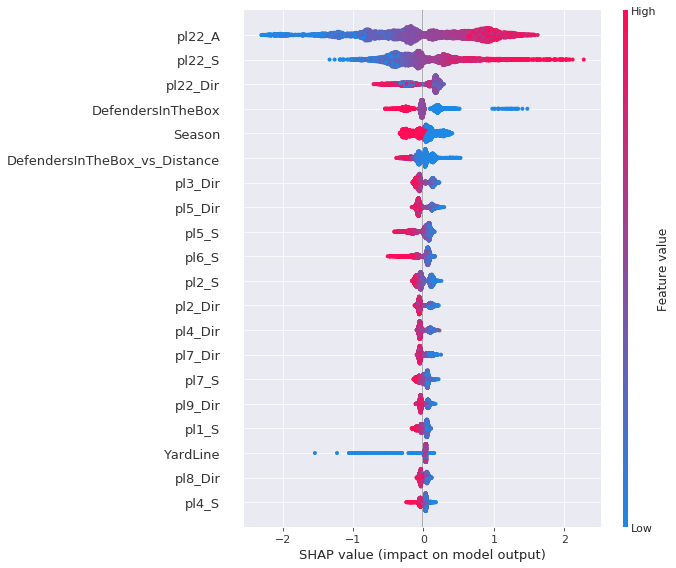

In [99]:
shap.summary_plot(shap_values, X_val)